In [1]:
import keras
keras.__version__

'2.8.0'

# Utilizando convnets con datasets pequeños

Lo primero que tienes que hacer es descargarte el dataset de https://lara.web.cern.ch/lara/train.zip en la terminal de Jupyter y descomprimirlo en la misma carpeta donde se encuentra esta libreta. 

Para descargar otro conjunto de datos desde imagenet se puede descargar la lista con las URL a las imágenes y usar `wget -i`



## Entrenando desde 0 una convNet

Entrenar un modelo de clasificación de imágenes con muy pocos datos es una situación común en la que te encontrarás si acabas dedicándote a hacer Computer Vision en un contexto profesional. 

Tener "pocas" muestras puede significar cualquier cosa entre unos pocos cientos y unas pocas decenas de miles de imágenes. Vamos a ilustrar aqui un ejemplo práctico: vamos a centrarnos en clasificar imágenes como "perros" y "gatos".


## La relevancia del Deep Learning en problemas con pocos datos

Quizás habrás oido muchas veces que el Deep Learning solo funciona cuando se tienen grandes cantidades de datos. Esto en parte es verdad: una de las características del Deep learning es que puede encontrar características interesantes a partir del dataset de entrenamiento por si mismo, y esto a priori es más sencillo cuando se tienen muchos ejemplos disponibles, especialmente en el caso de tener datasets de input con una alta dimensionalidad, como es el caso de las imágenes.

Sin embargo, lo que constituye un dataset "grande" es relativo. Concretamente relativo al tamaño y la profundidad de la red que estamos intentando entrenar. No es posible enrenar una convnet para que resulta un problema completo con solo unas decenas de ejemplos, pero unos pocos cientos puede ser suficiente si el modelo está bien montado (entenderemos que significa bien "montado" a lo largo del curso de Deep Learning).

Como las convnets aprenden características locales, invariantes bajo translaciones, son muy eficientes en cuanto al número de imágenes necesarias para llevar a cabo problemas perceptuales. Así que entrenar una convnet desde 0 con un dataset no muy grande aún nos puede llevar a resultados razonables como veremos aqui.

Pero hay más aún: los modelos de Deep Learning son altamente "reciclables". Uno puede coger, por ejemplo, un problema de clasificación de imagen y un convertidor de voz a texto entrenado sobre un dataset muy grande y luego reutilizarlo para resolver otro problema completamente distinto solo añadiéndole pequeñas modificaciones. Más especificamente, en el caso de Computer Vision, muchos modelos pre-entrenados (normalmente entrenados en el dataset ImageNet) son hechos publicos para que uno pueda descargarlos y utilizarlos para crear potentes modelos de Computer Vision con muy pocos datos. 

Pero aqui nos vamos a limitar a correr un ejemplo sencillito. 


## Los datos

El dataset de gatos vs perros que utilizamos no es un paquete de Keras. Se publicó en Kaggle.com como parte de un problema de Computer Vision a finales de 2013, cuando todavía las ConvNets no eran tan populares. 

Las imágenes son JPGEs de resolución media. Tiene este aspecto:

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

No es ninguna sorpresa que la competición de gatos vs perros de Kaggle en 2013 fuera ganada por ConvNets. Los mejores pudieron alcanzar una precisión de hasta 95%. En nuestro ejemplo vamos a quedarnos todavía lejos de esta precisión, pero durante el curso de Deep Learning hemos aprendido como acercarnos a este valor utilizando diversos métodos para mejorar el rendimiento de las redes neuronales. Hay que tener en cuenta que en este ejemplo estamos entrenando aproximadamente sobre solo el 10% de los datos que se utilizaron para el concurso. 
Después de descargar el dataset y descomprimirlo, vamos a crear un nuevo dataset que contiene tres subsets: un set de training que contiene 1000 imágenes de cada clase, un set de validación con 500 imágenes de cada clase, y finalmente un set de test con 500 imágenes de cada clase.

Aqui tenemos unas cuantas líneas de código que nos hacen este reparto automáticamente:



In [2]:
import os, shutil

As a sanity check, let's count how many pictures we have in each training split (train/validation/test):

In [3]:
print('total training cat images:', 
      len(os.listdir(r"C:\Users\pcalatayud\Desktop\jupyter\ML1\practicas\clasificando-imagenes\train\cats_and_dogs_small\train\cats")))

total training cat images: 1000


In [4]:
print('total training dog images:', 
      len(os.listdir(r"C:\Users\pcalatayud\Desktop\jupyter\ML1\practicas\clasificando-imagenes\train\cats_and_dogs_small\train\dogs")))

total training dog images: 1000


In [5]:
print('total validation cat images:', 
      len(os.listdir(r"C:\Users\pcalatayud\Desktop\jupyter\ML1\practicas\clasificando-imagenes\train\cats_and_dogs_small\validation\cats")))

total validation cat images: 500


In [6]:
print('total validation dog images:', 
      len(os.listdir(r"C:\Users\pcalatayud\Desktop\jupyter\ML1\practicas\clasificando-imagenes\train\cats_and_dogs_small\validation\dogs")))

total validation dog images: 500


In [7]:
print('total test cat images:', 
      len(os.listdir(r"C:\Users\pcalatayud\Desktop\jupyter\ML1\practicas\clasificando-imagenes\train\cats_and_dogs_small\test\cats")))

total test cat images: 500


In [8]:
print('total test dog images:', 
      len(os.listdir(r"C:\Users\pcalatayud\Desktop\jupyter\ML1\practicas\clasificando-imagenes\train\cats_and_dogs_small\test\dogs")))

total test dog images: 500



Así que efectivamente tenemos 2000 imágenes de entrenamiento, 1000 imágenes de validación y 1000 imágenes de test. En cada uno de estos subsets hay el mismo número de ejemplos de cada clase: esto es lo que se llama un sistema de clasificación binario balanceado, lo cual significa que nuestra precisión de clasificación será una métrica adecuada del éxito de nuestra solución.

## Construyendo nuestra red

En el anterior ejemplo hemos construido una pequeña convnet para resolver el problema de clasificar números escritos a mano usando el dataset MNIST, así que ya estamos familiarizados con la terminología que utiliza keras. Vamos a reutilizar la estructura general que teniamos en el ejemplo anterior: nuestra convnet tendra una pila de capas alternadas de `Conv2D` (con activación `relu` ) y capas  `MaxPooling2D`.

Sin embargo, como estamos tratando con imágenes mayores y un problema más complejo, vamos a crear nuestra red en consecuencia: tendrá una capa más de `Conv2D` + `MaxPooling2D`. Esto sirve para aumentar la capacidad de la red y para reducir aún más el tamaño de los mapas de características, para que no sean tan enormes cuando lleguen al paso de aplanado. Empezamos usando imágenes de input de 150x150 (una elección arbitraria), y acabaremos con mapas de características que tienen un tamaño de 7x7 antes de la capa de aplanamiento.

Es importante tener en cuenta que la profundidad de los mapas de características va creciendo progresivamente según se avanza en la red neuronales ( de 32 a 128) mientras que el tamaño de los mapas de características va disminuyendo (de 148x148 a 7x7). Este patrón lo verás en casi todas las convnets.

Como estamos atacando un problema de clasificación binaria (perro o gato), vamos a acabar la red con una única unidad (una capa densa de tamaño 1) y con una activación sigmoide. Esta unidad codificará la probabilidad de que nuestra red esté mirando a una clase o a otra.

El aspecto final del modelo debe de ser el siguiente:

![modelo_red_animales.png](https://github.com/laramaktub/MachineLearningI/blob/master/modelo_red_animales.png?raw=true)

Para el paso de compilación utilizaremos el optimizador `RMSprop`(lr=1e-4). Como nuestra red termina con una única unidad sigmoide, vamos a utilizar binary crossentropy como nuestra función de pérdida.

In [9]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [10]:
from tensorflow import keras
from keras import optimizers
optimizer=keras.optimizers.RMSprop(learning_rate=0.001)
#Añado el compilador

model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=['acc'])

##  Preprocesado de datos

Las imágenes deben estar formateadas apropiadamente en tensores de flotantes antes de dárselas a la red. Esto es justo lo que vamos a hacer aqui. Antes de preprocesarlas las imágenes son archivos JPEG. Los pasos para poder darlos a nuestra red son a grandes rasgos:

* Leer los archivos con las imágenes.
* Decodificar el contenido del JPEG en una "parrilla" con el RGB de los pixels 
* Convertir esa "parrilla" en tensores de flotantes
* Re-escalar los valores de los pixels (enre 0 y 255) al intervalo [0, 1] ya que las redes neuronales prefieren trabajar con valores pequeños. 

Todo esto puede parecer muy complicado pero gracias a Keras nuestra vida es mucho más fácil y podemos contar con tus herramientas para ocuparse de estos pasos automaticamente. Keras tiene un módulo con herramientas para el tratamiento de imágenes, que se puede encontrar en  `keras.preprocessing.image`. En particular, contiene la clase `ImageDataGenerator` que nos permite automaticamente convertir imágenes que tengamos en el disco duro en tensores pre-procesados. Esto es justamente lo que usaremos a continuación. Para ello podemos utilizar el flow_from_directory para coger las imágenes directamente de las carpetas que generamos previamente. Le damos como entrada las carpetas donde están las imágenes de entrenamiento (o validación), el tamaño de las imágenes (target_size), tamaño del batch que vamos a usar (vamos a empezar por 20) y como solo hay dos categorías, le decimos que vamos a usar binary_crossentropy (class_mode). Al correr estos comandos obtendremos lo siguiente el número total de imágenes y cuantas clases hay.

In [11]:
from keras.preprocessing.image import ImageDataGenerator

#Normalizacion
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255) 



In [12]:
#Procesamiento para train y validacion
train_generator = train_datagen.flow_from_directory(r'C:\Users\pcalatayud\Desktop\jupyter\ML1\practicas\clasificando-imagenes\train\cats_and_dogs_small\train', 
                                                    target_size=(150, 150), class_mode='binary', batch_size=20)
validation_generator = validation_datagen.flow_from_directory(r'C:\Users\pcalatayud\Desktop\jupyter\ML1\practicas\clasificando-imagenes\train\cats_and_dogs_small\validation', 
                                                              target_size=(150, 150), class_mode='binary', batch_size=20)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Vamos a echar un vistazo a uno de estos generadores: nos lleva a un batch de 150x150 imágenes RGB (dimensiones `(20, 150, 150, 3)`) y etiquetas binarias (dimensión `(20,)`). 20 es el número de ejemplos en cada batch (lo que llamamos el tamaño del batch). El generador genera estos batches de manera indefinida: corre un bucle sin cesar por todas las imágenes que tengamos en la carpeta. Por eso tenemos que escribir `break` para romper el bucle en algún momento.


In [13]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Ahora vamos a hacer el fit. En este caso, como lo que tenemos es un generator, utilizamos fit_generator. Vamos a correr 30 épocas y a utilizar el dataset de validación.

In [14]:
from PIL import ImageFile

#Tratamiento de imagen para convertirla en un formato adeacuado que no de error.

ImageFile.LOAD_TRUNCATED_IMAGES = True

history = model.fit_generator(train_generator, epochs=30, verbose=1, validation_data=validation_generator)

Epoch 1/30


C:\Users\PCALAT~1\AppData\Local\Temp/ipykernel_35344/3866466407.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=30, verbose=1, validation_data=validation_generator)


100/100 [==============================] - 24s 232ms/step - loss: 0.7618 - acc: 0.5180 - val_loss: 0.6886 - val_acc: 0.5190
Epoch 2/30
100/100 [==============================] - 24s 239ms/step - loss: 0.6846 - acc: 0.5725 - val_loss: 0.6595 - val_acc: 0.6470
Epoch 3/30
100/100 [==============================] - 25s 245ms/step - loss: 0.6392 - acc: 0.6560 - val_loss: 0.5944 - val_acc: 0.6860
Epoch 4/30
100/100 [==============================] - 24s 240ms/step - loss: 0.5669 - acc: 0.7170 - val_loss: 0.6234 - val_acc: 0.6340
Epoch 5/30
100/100 [==============================] - 24s 237ms/step - loss: 0.5202 - acc: 0.7520 - val_loss: 0.5512 - val_acc: 0.7450
Epoch 6/30
100/100 [==============================] - 25s 250ms/step - loss: 0.4823 - acc: 0.7775 - val_loss: 0.5328 - val_acc: 0.7440
Epoch 7/30
100/100 [==============================] - 31s 307ms/step - loss: 0.4175 - acc: 0.8180 - val_loss: 0.6124 - val_acc: 0.7140
Epoch 8/30
100/100 [==============================] - 30s 304ms/st

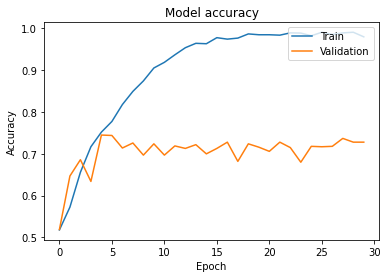

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#Grafica Acuracy de TRAIN-VALIDATION

Es una buena idea guardar el modelo después de entrenar:

In [16]:
#Se guarda el modelo
model.save(r'C:\Users\pcalatayud\Desktop\jupyter\ML1\practicas\clasificando-imagenes\model1_CNN.h5')

Ahora evalua el modelo en el dataset de test.

In [17]:
from keras.models import load_model
#Se carga el modelo
model = load_model(r'C:\Users\pcalatayud\Desktop\jupyter\ML1\practicas\clasificando-imagenesmodel1_CNN.h5')

In [18]:
#Ajustamos el conjunto de test para poder evaluar el modelo con el set de test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(r'C:\Users\pcalatayud\Desktop\jupyter\ML1\practicas\clasificando-imagenes\train\cats_and_dogs_small\test', target_size=(150, 150), class_mode='binary', batch_size=20)

Found 1000 images belonging to 2 classes.


In [19]:
#Evaluacion del modelo
model.evaluate(test_generator, verbose=1)

50/50 [==============================] - 3s 64ms/step - loss: 0.6932 - acc: 0.5000


[0.69315505027771, 0.5]

Prueba a optimizar la red. Para ello puedes utilizar las herramientas utilizadas en clase. Puedes probar a optimizar en términos de velocidad y de accuracy. Comenta los resultados.

In [ ]:
#Se aumenta el numero de epocoas, 
#se cambia  el learning rate 
#se guarda el mejor modelo

In [50]:
from keras import backend as K

K.clear_session()

In [51]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 64)        0

In [52]:
from tensorflow import keras
from keras import optimizers
optimizer=keras.optimizers.RMSprop(learning_rate=0.001*0.75)
#Añado el compilador

model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=['acc'])

In [53]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255) #normalizar y dividir entre 255


In [54]:
#Procesamiento para train y validacion
train_generator = train_datagen.flow_from_directory(r'C:\Users\pcalatayud\Desktop\jupyter\ML1\practicas\clasificando-imagenes\train\cats_and_dogs_small\train', 
                                                    target_size=(150, 150), class_mode='binary', batch_size=20)
validation_generator = validation_datagen.flow_from_directory(r'C:\Users\pcalatayud\Desktop\jupyter\ML1\practicas\clasificando-imagenes\train\cats_and_dogs_small\validation', 
                                                              target_size=(150, 150), class_mode='binary', batch_size=20)



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [55]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

checkpointer = ModelCheckpoint(filepath=r'C:\Users\pcalatayud\Desktop\jupyter\ML1\practicas\clasificando-imagenes\train\cats_and_dogs_small_model_best' + '.h5', verbose=0, save_best_only=True)
#earlystopper = EarlyStopping(monitor='val_acc', patience=50, verbose=1)

In [58]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

history = model.fit_generator(train_generator, epochs=1000, verbose=1, callbacks=[checkpointer], validation_data=validation_generator)

Epoch 1/1000


C:\Users\PCALAT~1\AppData\Local\Temp/ipykernel_35344/2947221850.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=1000, verbose=1, callbacks=[checkpointer], validation_data=validation_generator)


100/100 [==============================] - 26s 257ms/step - loss: 0.1273 - acc: 0.9620 - val_loss: 1.0650 - val_acc: 0.7590
Epoch 2/1000
100/100 [==============================] - 27s 273ms/step - loss: 0.1542 - acc: 0.9585 - val_loss: 1.1469 - val_acc: 0.7430
Epoch 3/1000
100/100 [==============================] - 29s 288ms/step - loss: 0.1677 - acc: 0.9515 - val_loss: 0.9495 - val_acc: 0.7650
Epoch 4/1000
100/100 [==============================] - 27s 269ms/step - loss: 0.1348 - acc: 0.9670 - val_loss: 0.8227 - val_acc: 0.7340
Epoch 5/1000
100/100 [==============================] - 27s 268ms/step - loss: 0.1589 - acc: 0.9610 - val_loss: 0.9255 - val_acc: 0.7380
Epoch 6/1000
100/100 [==============================] - 33s 326ms/step - loss: 0.1840 - acc: 0.9520 - val_loss: 1.1414 - val_acc: 0.7360
Epoch 7/1000
100/100 [==============================] - 36s 360ms/step - loss: 0.1618 - acc: 0.9560 - val_loss: 1.1254 - val_acc: 0.7350
Epoch 8/1000
100/100 [==============================] 

100/100 [==============================] - 42s 423ms/step - loss: 0.1685 - acc: 0.9540 - val_loss: 1.0024 - val_acc: 0.7300
Epoch 61/1000
100/100 [==============================] - 39s 390ms/step - loss: 0.1908 - acc: 0.9500 - val_loss: 1.3693 - val_acc: 0.7490
Epoch 62/1000
100/100 [==============================] - 40s 395ms/step - loss: 0.1775 - acc: 0.9485 - val_loss: 0.6406 - val_acc: 0.7500
Epoch 63/1000
100/100 [==============================] - 40s 398ms/step - loss: 0.2015 - acc: 0.9540 - val_loss: 1.0037 - val_acc: 0.7560
Epoch 64/1000
100/100 [==============================] - 40s 401ms/step - loss: 0.1771 - acc: 0.9540 - val_loss: 1.2353 - val_acc: 0.7650
Epoch 65/1000
100/100 [==============================] - 44s 440ms/step - loss: 0.1392 - acc: 0.9585 - val_loss: 1.6970 - val_acc: 0.7720
Epoch 66/1000
100/100 [==============================] - 42s 415ms/step - loss: 0.3718 - acc: 0.9415 - val_loss: 0.8171 - val_acc: 0.7600
Epoch 67/1000
100/100 [=========================

100/100 [==============================] - 51s 508ms/step - loss: 0.1905 - acc: 0.9500 - val_loss: 1.2466 - val_acc: 0.7630
Epoch 120/1000
100/100 [==============================] - 51s 507ms/step - loss: 0.2118 - acc: 0.9435 - val_loss: 0.8200 - val_acc: 0.7410
Epoch 121/1000
100/100 [==============================] - 51s 506ms/step - loss: 0.1977 - acc: 0.9520 - val_loss: 0.8009 - val_acc: 0.7170
Epoch 122/1000
100/100 [==============================] - 51s 507ms/step - loss: 0.2279 - acc: 0.9345 - val_loss: 0.9371 - val_acc: 0.7580
Epoch 123/1000
100/100 [==============================] - 51s 511ms/step - loss: 0.1989 - acc: 0.9435 - val_loss: 0.8424 - val_acc: 0.7630
Epoch 124/1000
100/100 [==============================] - 52s 519ms/step - loss: 0.2071 - acc: 0.9475 - val_loss: 1.2808 - val_acc: 0.7480
Epoch 125/1000
100/100 [==============================] - 51s 510ms/step - loss: 0.2694 - acc: 0.9370 - val_loss: 0.9429 - val_acc: 0.7690
Epoch 126/1000
100/100 [==================

100/100 [==============================] - 35s 352ms/step - loss: 0.2175 - acc: 0.9395 - val_loss: 0.5805 - val_acc: 0.7780
Epoch 179/1000
100/100 [==============================] - 36s 358ms/step - loss: 0.2184 - acc: 0.9485 - val_loss: 0.6372 - val_acc: 0.7670
Epoch 180/1000
100/100 [==============================] - 36s 361ms/step - loss: 0.2339 - acc: 0.9375 - val_loss: 0.5596 - val_acc: 0.7280
Epoch 181/1000
100/100 [==============================] - 36s 360ms/step - loss: 0.2899 - acc: 0.9355 - val_loss: 0.6520 - val_acc: 0.7250
Epoch 182/1000
100/100 [==============================] - 36s 357ms/step - loss: 0.2169 - acc: 0.9470 - val_loss: 1.1117 - val_acc: 0.7300
Epoch 183/1000
100/100 [==============================] - 36s 358ms/step - loss: 0.2308 - acc: 0.9480 - val_loss: 0.8546 - val_acc: 0.7280
Epoch 184/1000
100/100 [==============================] - 36s 360ms/step - loss: 0.2216 - acc: 0.9330 - val_loss: 0.7885 - val_acc: 0.7470
Epoch 185/1000
100/100 [==================

100/100 [==============================] - 37s 365ms/step - loss: 0.2621 - acc: 0.9375 - val_loss: 0.5705 - val_acc: 0.7870
Epoch 238/1000
100/100 [==============================] - 35s 355ms/step - loss: 0.2482 - acc: 0.9305 - val_loss: 0.5973 - val_acc: 0.7800
Epoch 239/1000
100/100 [==============================] - 36s 356ms/step - loss: 0.2621 - acc: 0.9420 - val_loss: 0.7520 - val_acc: 0.7760
Epoch 240/1000
100/100 [==============================] - 37s 372ms/step - loss: 0.2560 - acc: 0.9120 - val_loss: 1.0904 - val_acc: 0.7890
Epoch 241/1000
100/100 [==============================] - 36s 361ms/step - loss: 0.2662 - acc: 0.9395 - val_loss: 0.7691 - val_acc: 0.7550
Epoch 242/1000
100/100 [==============================] - 36s 356ms/step - loss: 0.2264 - acc: 0.9385 - val_loss: 0.9888 - val_acc: 0.6880
Epoch 243/1000
100/100 [==============================] - 37s 374ms/step - loss: 0.2512 - acc: 0.9345 - val_loss: 0.6771 - val_acc: 0.7470
Epoch 244/1000
100/100 [==================

100/100 [==============================] - 36s 356ms/step - loss: 0.4504 - acc: 0.9420 - val_loss: 0.9413 - val_acc: 0.7790
Epoch 297/1000
100/100 [==============================] - 36s 358ms/step - loss: 0.1778 - acc: 0.9455 - val_loss: 1.2242 - val_acc: 0.7810
Epoch 298/1000
100/100 [==============================] - 36s 359ms/step - loss: 0.2612 - acc: 0.9275 - val_loss: 0.6135 - val_acc: 0.7620
Epoch 299/1000
100/100 [==============================] - 35s 351ms/step - loss: 0.2558 - acc: 0.9275 - val_loss: 0.6046 - val_acc: 0.7820
Epoch 300/1000
100/100 [==============================] - 35s 348ms/step - loss: 0.2946 - acc: 0.9395 - val_loss: 0.5761 - val_acc: 0.7810
Epoch 301/1000
100/100 [==============================] - 35s 354ms/step - loss: 0.3333 - acc: 0.9250 - val_loss: 0.6944 - val_acc: 0.7000
Epoch 302/1000
100/100 [==============================] - 35s 347ms/step - loss: 0.1891 - acc: 0.9460 - val_loss: 0.7759 - val_acc: 0.7610
Epoch 303/1000
100/100 [==================

100/100 [==============================] - 35s 345ms/step - loss: 0.2310 - acc: 0.9400 - val_loss: 0.6962 - val_acc: 0.7530
Epoch 356/1000
100/100 [==============================] - 36s 360ms/step - loss: 0.3943 - acc: 0.9270 - val_loss: 0.6399 - val_acc: 0.7350
Epoch 357/1000
100/100 [==============================] - 35s 355ms/step - loss: 0.2744 - acc: 0.9280 - val_loss: 0.6885 - val_acc: 0.7600
Epoch 358/1000
100/100 [==============================] - 37s 366ms/step - loss: 0.1904 - acc: 0.9410 - val_loss: 0.8433 - val_acc: 0.7680
Epoch 359/1000
100/100 [==============================] - 37s 366ms/step - loss: 0.2823 - acc: 0.9415 - val_loss: 0.7440 - val_acc: 0.7400
Epoch 360/1000
100/100 [==============================] - 36s 364ms/step - loss: 0.1900 - acc: 0.9490 - val_loss: 2.6656 - val_acc: 0.7250
Epoch 361/1000
100/100 [==============================] - 36s 362ms/step - loss: 0.2872 - acc: 0.9365 - val_loss: 0.7006 - val_acc: 0.7560
Epoch 362/1000
100/100 [==================

100/100 [==============================] - 42s 423ms/step - loss: 0.7469 - acc: 0.9140 - val_loss: 0.7066 - val_acc: 0.7500
Epoch 415/1000
100/100 [==============================] - 42s 418ms/step - loss: 0.1855 - acc: 0.9460 - val_loss: 0.9389 - val_acc: 0.7830
Epoch 416/1000
100/100 [==============================] - 41s 415ms/step - loss: 0.2367 - acc: 0.9195 - val_loss: 0.6797 - val_acc: 0.7280
Epoch 417/1000
100/100 [==============================] - 41s 414ms/step - loss: 0.2640 - acc: 0.9385 - val_loss: 0.8160 - val_acc: 0.7710
Epoch 418/1000
100/100 [==============================] - 42s 417ms/step - loss: 0.2973 - acc: 0.9370 - val_loss: 0.7509 - val_acc: 0.7790
Epoch 419/1000
100/100 [==============================] - 41s 406ms/step - loss: 0.1836 - acc: 0.9485 - val_loss: 1.0024 - val_acc: 0.7850
Epoch 420/1000
100/100 [==============================] - 39s 394ms/step - loss: 0.3369 - acc: 0.9325 - val_loss: 0.6420 - val_acc: 0.7640
Epoch 421/1000
100/100 [==================

100/100 [==============================] - 30s 303ms/step - loss: 0.2076 - acc: 0.9380 - val_loss: 0.5592 - val_acc: 0.7290
Epoch 474/1000
100/100 [==============================] - 30s 301ms/step - loss: 0.2546 - acc: 0.9350 - val_loss: 0.6116 - val_acc: 0.7440
Epoch 475/1000
100/100 [==============================] - 35s 346ms/step - loss: 0.2886 - acc: 0.9350 - val_loss: 1.0203 - val_acc: 0.7880
Epoch 476/1000
100/100 [==============================] - 39s 393ms/step - loss: 0.2228 - acc: 0.9355 - val_loss: 0.6229 - val_acc: 0.6920
Epoch 477/1000
100/100 [==============================] - 36s 356ms/step - loss: 0.2531 - acc: 0.9285 - val_loss: 0.6875 - val_acc: 0.7080
Epoch 478/1000
100/100 [==============================] - 32s 321ms/step - loss: 0.2571 - acc: 0.9370 - val_loss: 0.8059 - val_acc: 0.7680
Epoch 479/1000
100/100 [==============================] - 31s 314ms/step - loss: 0.2295 - acc: 0.9345 - val_loss: 1.2441 - val_acc: 0.7400
Epoch 480/1000
100/100 [==================

100/100 [==============================] - 33s 330ms/step - loss: 0.2446 - acc: 0.9400 - val_loss: 0.6118 - val_acc: 0.7830
Epoch 533/1000
100/100 [==============================] - 33s 332ms/step - loss: 0.2454 - acc: 0.9315 - val_loss: 0.6584 - val_acc: 0.7470
Epoch 534/1000
100/100 [==============================] - 33s 332ms/step - loss: 0.2836 - acc: 0.9050 - val_loss: 0.7133 - val_acc: 0.6490
Epoch 535/1000
100/100 [==============================] - 33s 330ms/step - loss: 0.2831 - acc: 0.9320 - val_loss: 0.5915 - val_acc: 0.7990
Epoch 536/1000
100/100 [==============================] - 33s 333ms/step - loss: 0.2123 - acc: 0.9320 - val_loss: 0.6440 - val_acc: 0.7460
Epoch 537/1000
100/100 [==============================] - 33s 330ms/step - loss: 0.2410 - acc: 0.9325 - val_loss: 0.6569 - val_acc: 0.7580
Epoch 538/1000
100/100 [==============================] - 33s 334ms/step - loss: 0.2698 - acc: 0.9350 - val_loss: 0.6712 - val_acc: 0.7510
Epoch 539/1000
100/100 [==================

100/100 [==============================] - 34s 337ms/step - loss: 0.2976 - acc: 0.9350 - val_loss: 0.6256 - val_acc: 0.7400
Epoch 592/1000
100/100 [==============================] - 34s 339ms/step - loss: 0.3334 - acc: 0.9225 - val_loss: 0.5973 - val_acc: 0.7540
Epoch 593/1000
100/100 [==============================] - 34s 335ms/step - loss: 0.2938 - acc: 0.9145 - val_loss: 0.5773 - val_acc: 0.7530
Epoch 594/1000
100/100 [==============================] - 33s 326ms/step - loss: 0.5734 - acc: 0.9275 - val_loss: 0.7051 - val_acc: 0.5950
Epoch 595/1000
100/100 [==============================] - 33s 335ms/step - loss: 0.2681 - acc: 0.9295 - val_loss: 0.6366 - val_acc: 0.7180
Epoch 596/1000
100/100 [==============================] - 34s 340ms/step - loss: 0.2196 - acc: 0.9435 - val_loss: 2.1858 - val_acc: 0.7040
Epoch 597/1000
100/100 [==============================] - 34s 336ms/step - loss: 0.2812 - acc: 0.9320 - val_loss: 0.6225 - val_acc: 0.7470
Epoch 598/1000
100/100 [==================

100/100 [==============================] - 34s 338ms/step - loss: 0.2485 - acc: 0.9340 - val_loss: 0.6604 - val_acc: 0.7490
Epoch 651/1000
100/100 [==============================] - 32s 325ms/step - loss: 0.2965 - acc: 0.9155 - val_loss: 0.6683 - val_acc: 0.6660
Epoch 652/1000
100/100 [==============================] - 33s 332ms/step - loss: 0.3015 - acc: 0.9245 - val_loss: 0.6008 - val_acc: 0.7400
Epoch 653/1000
100/100 [==============================] - 34s 338ms/step - loss: 0.3253 - acc: 0.9325 - val_loss: 3.9561 - val_acc: 0.7880
Epoch 654/1000
100/100 [==============================] - 34s 338ms/step - loss: 0.2823 - acc: 0.9280 - val_loss: 0.8422 - val_acc: 0.7690
Epoch 655/1000
100/100 [==============================] - 33s 330ms/step - loss: 0.2974 - acc: 0.9265 - val_loss: 0.6750 - val_acc: 0.7430
Epoch 656/1000
100/100 [==============================] - 33s 334ms/step - loss: 0.3014 - acc: 0.9145 - val_loss: 0.6506 - val_acc: 0.7150
Epoch 657/1000
100/100 [==================

100/100 [==============================] - 34s 338ms/step - loss: 0.2643 - acc: 0.9160 - val_loss: 0.6688 - val_acc: 0.7100
Epoch 710/1000
100/100 [==============================] - 34s 338ms/step - loss: 0.3177 - acc: 0.9170 - val_loss: 0.7353 - val_acc: 0.6790
Epoch 711/1000
100/100 [==============================] - 34s 343ms/step - loss: 0.2365 - acc: 0.9410 - val_loss: 0.7782 - val_acc: 0.7570
Epoch 712/1000
100/100 [==============================] - 34s 339ms/step - loss: 0.3625 - acc: 0.9220 - val_loss: 0.6409 - val_acc: 0.7380
Epoch 713/1000
100/100 [==============================] - 34s 341ms/step - loss: 0.3111 - acc: 0.9325 - val_loss: 0.5362 - val_acc: 0.7750
Epoch 714/1000
100/100 [==============================] - 35s 347ms/step - loss: 0.3446 - acc: 0.9115 - val_loss: 0.6663 - val_acc: 0.6790
Epoch 715/1000
100/100 [==============================] - 34s 343ms/step - loss: 0.2862 - acc: 0.9160 - val_loss: 0.7772 - val_acc: 0.7500
Epoch 716/1000
100/100 [==================

100/100 [==============================] - 34s 345ms/step - loss: 0.2890 - acc: 0.9055 - val_loss: 0.6840 - val_acc: 0.6970
Epoch 769/1000
100/100 [==============================] - 34s 343ms/step - loss: 0.4510 - acc: 0.8965 - val_loss: 0.5947 - val_acc: 0.7230
Epoch 770/1000
100/100 [==============================] - 34s 343ms/step - loss: 0.2702 - acc: 0.9280 - val_loss: 0.7626 - val_acc: 0.6750
Epoch 771/1000
100/100 [==============================] - 34s 343ms/step - loss: 0.2771 - acc: 0.9140 - val_loss: 0.6168 - val_acc: 0.7270
Epoch 772/1000
100/100 [==============================] - 35s 347ms/step - loss: 0.3523 - acc: 0.9200 - val_loss: 0.6692 - val_acc: 0.6740
Epoch 773/1000
100/100 [==============================] - 35s 346ms/step - loss: 0.3100 - acc: 0.8955 - val_loss: 0.6381 - val_acc: 0.7960
Epoch 774/1000
100/100 [==============================] - 35s 350ms/step - loss: 0.4931 - acc: 0.9155 - val_loss: 0.6740 - val_acc: 0.7420
Epoch 775/1000
100/100 [==================

100/100 [==============================] - 33s 331ms/step - loss: 0.3166 - acc: 0.8910 - val_loss: 0.7379 - val_acc: 0.6820
Epoch 828/1000
100/100 [==============================] - 33s 331ms/step - loss: 0.3272 - acc: 0.8975 - val_loss: 0.6825 - val_acc: 0.7100
Epoch 829/1000
100/100 [==============================] - 34s 337ms/step - loss: 0.2971 - acc: 0.9095 - val_loss: 0.7050 - val_acc: 0.7000
Epoch 830/1000
100/100 [==============================] - 34s 337ms/step - loss: 0.3283 - acc: 0.9010 - val_loss: 0.7100 - val_acc: 0.7020
Epoch 831/1000
100/100 [==============================] - 33s 329ms/step - loss: 0.3223 - acc: 0.9000 - val_loss: 0.7922 - val_acc: 0.6230
Epoch 832/1000
100/100 [==============================] - 33s 329ms/step - loss: 0.3650 - acc: 0.8740 - val_loss: 0.6457 - val_acc: 0.6910
Epoch 833/1000
100/100 [==============================] - 34s 336ms/step - loss: 0.2995 - acc: 0.8965 - val_loss: 0.4975 - val_acc: 0.7900
Epoch 834/1000
100/100 [==================

100/100 [==============================] - 33s 331ms/step - loss: 0.4395 - acc: 0.9105 - val_loss: 0.5877 - val_acc: 0.7710
Epoch 887/1000
100/100 [==============================] - 34s 337ms/step - loss: 0.3254 - acc: 0.9070 - val_loss: 0.6514 - val_acc: 0.7610
Epoch 888/1000
100/100 [==============================] - 34s 336ms/step - loss: 0.3849 - acc: 0.8875 - val_loss: 0.5436 - val_acc: 0.7610
Epoch 889/1000
100/100 [==============================] - 33s 333ms/step - loss: 0.3352 - acc: 0.8920 - val_loss: 0.5457 - val_acc: 0.7520
Epoch 890/1000
100/100 [==============================] - 34s 338ms/step - loss: 0.3726 - acc: 0.8950 - val_loss: 0.5969 - val_acc: 0.7480
Epoch 891/1000
100/100 [==============================] - 33s 333ms/step - loss: 0.3222 - acc: 0.9015 - val_loss: 0.7518 - val_acc: 0.6670
Epoch 892/1000
100/100 [==============================] - 33s 334ms/step - loss: 0.2804 - acc: 0.9165 - val_loss: 0.5882 - val_acc: 0.7770
Epoch 893/1000
100/100 [==================

100/100 [==============================] - 34s 340ms/step - loss: 0.2513 - acc: 0.9095 - val_loss: 0.7402 - val_acc: 0.6860
Epoch 946/1000
100/100 [==============================] - 34s 339ms/step - loss: 0.3359 - acc: 0.8930 - val_loss: 0.5972 - val_acc: 0.8090
Epoch 947/1000
100/100 [==============================] - 34s 335ms/step - loss: 0.4133 - acc: 0.9125 - val_loss: 0.8873 - val_acc: 0.6220
Epoch 948/1000
100/100 [==============================] - 35s 346ms/step - loss: 0.3515 - acc: 0.8860 - val_loss: 0.9687 - val_acc: 0.5560
Epoch 949/1000
100/100 [==============================] - 34s 339ms/step - loss: 0.3426 - acc: 0.8910 - val_loss: 0.6815 - val_acc: 0.7630
Epoch 950/1000
100/100 [==============================] - 34s 345ms/step - loss: 0.3127 - acc: 0.9075 - val_loss: 0.7219 - val_acc: 0.6940
Epoch 951/1000
100/100 [==============================] - 34s 337ms/step - loss: 0.3111 - acc: 0.8965 - val_loss: 0.7272 - val_acc: 0.6760
Epoch 952/1000
100/100 [==================

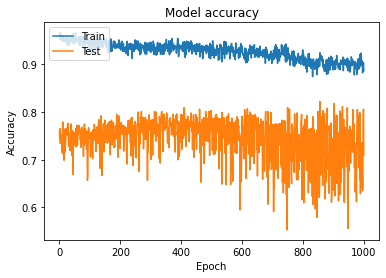

In [59]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [60]:
from keras.models import load_model
#cargamos el mejor modelo guardado
model_improved = load_model(r'C:\Users\pcalatayud\Desktop\jupyter\ML1\practicas\clasificando-imagenes\train\cats_and_dogs_small_model_best.h5')

In [61]:
#Cargamos test para poder evaluar el modelo en ellos
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(r'C:\Users\pcalatayud\Desktop\jupyter\ML1\practicas\clasificando-imagenes\train\cats_and_dogs_small\test', 
                                                  target_size=(150, 150), class_mode='binary', batch_size=20)

Found 1000 images belonging to 2 classes.


In [62]:
model_improved.evaluate(test_generator, verbose=1)

50/50 [==============================] - 4s 82ms/step - loss: 0.5375 - acc: 0.7660


[0.5375460386276245, 0.765999972820282]

In [63]:
model.evaluate(test_generator, verbose=1)

50/50 [==============================] - 4s 74ms/step - loss: 0.7055 - acc: 0.7110


[0.7054948806762695, 0.7110000252723694]

In [ ]:
#Hay una mejora entre el modelo inicial y el modelo mejorado en el conjunto de test